<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>

<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/geodfprepro/blob/main/GeoDF_Operations.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Basic spatial operations in  Geo Dataframes

We will review some important formatting processes for geodataframes. As usual, let's do this:

1. Create a repository named: **geodfprepro**.
2. Clone that repo to a local folder in your computer.
3. In that local folder in your computer, create a folder named **maps** and **data**.
4. Put the **brazilMaps_5641.gpkg**  file that contains the three maps prepared last class into the map folder.
5. Download the shapefile of "Brazil - Subnational Administrative Boundaries" from [here](https://data.humdata.org/dataset/cod-ab-bra) and save it in the maps folder (you need to unzip the file).
6. Download a **CSV** file with information on the airports in Brazil from this [website](https://data.humdata.org/dataset/ourairports-bra), I will save it in my **data** folder:
7. Commit and push.

Let's read _Brazil_5641.gpkg_ from the GitHub link with the help of **geopandas**:

In [1]:
import os


import geopandas as gpd
from  fiona import listlayers

#maps
brazilMaps='https://github.com/juandiegopozo-10/geodfprepro/raw/main/maps/brazilMaps_5641.gpkg'

#layers in maps
listlayers(brazilMaps)

['country', 'cities', 'rivers']

Retrieving each map (layer):

In [2]:
brazil=gpd.read_file(brazilMaps,layer='country')
brazil_cities=gpd.read_file(brazilMaps,layer='cities')
brazil_rivers=gpd.read_file(brazilMaps,layer='rivers')

We know they share the same CRS:

In [3]:
brazil.crs.to_epsg()==brazil_cities.crs.to_epsg()==brazil_rivers.crs.to_epsg()

True

We also remember that having the same CRS allows one plot with several layers of maps:

<Axes: >

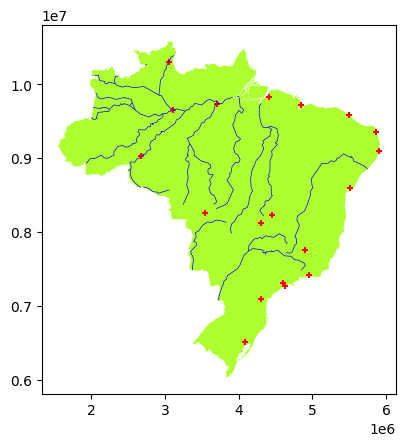

In [4]:
# plotting
base = brazil.plot(facecolor="greenyellow")
brazil_rivers.plot(edgecolor='blue', linewidth=0.5,ax=base)
brazil_cities.plot(marker='+', color='red', markersize=15,ax=base)

Now, let's see some important spatial operations:

1. [Formatting Projection](#1)
    * [Projecting Geoseries](#11)
    * [Projecting Naive Geodata](#12)
    * [Projecting long/lat](#13)
    
2. [Combining GeoDF rows](#2)
    * [Dissolving](#21)
    * [Unary union](#22)
      
4. [Creating Spatial Points](#3)
    * [Creating a convex hull](#31)
5. [Checking Validity](#4)



<a class="anchor" id="11"></a>

## Formating Geoseries projections



You know **brazil_5641** is a multipolygon:

In [5]:
brazil

,COUNTRY,geometry
0,Brazil,"MULTIPOLYGON (((1926257.542 8894978.397, 19262..."


Sometime, you just need the border (lines):

In [6]:
brazil.boundary

0    MULTILINESTRING ((1926257.542 8894978.397, 192...
dtype: geometry

<Axes: >

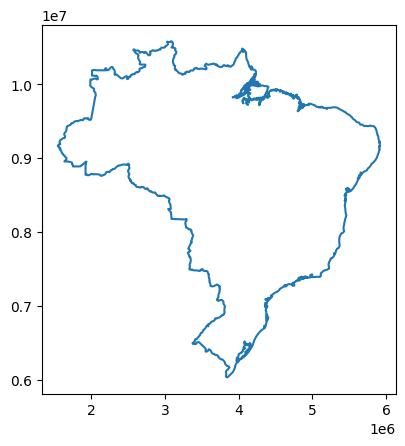

In [7]:
# This is just the borderline
brazil.boundary.plot()

Always check the data type:

In [8]:
# does 'boundary' return a GDF?
type(brazil.boundary)

geopandas.geoseries.GeoSeries

Some operations in geopandas require GDF or GS. If you need a GDF instead of a GS:

In [9]:
# converting into GDF
brazil.boundary.to_frame()

,0
0,"MULTILINESTRING ((1926257.542 8894978.397, 192..."


Notice you get a very simple GDF, and you may want to add some information:

In [ ]:
# conversion
brazil_border=brazil.boundary.to_frame()

# new column (optional)
brazil_border['name']='Brazil'

# renaming the geometry column
brazil_border.rename(columns={0:'geometry'},inplace=True)

#setting the geometry (the name is not enough)
brazil_border = brazil_border.set_geometry("geometry")

# verifying:
brazil_border.crs

You see you _multistring_:

In [ ]:
brazil_border

You can add this GDF as a layer:

### Exercise 1

<div class="alert-success">
    
1. Check if your country is a polygon or multipolygon.
    
2. Recover just the boundaries of that country.
    
3. Turn the boundary into a GDF.
</div>

<a class="anchor" id="12"></a>

## Lacking CRS information

Reprojecting seems a simple process, but you might find some interesting cases. Let's read the maps on _states_ and _municipalities_:

In [ ]:
brazil_states=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm1_ibge_2020.shp"))
brazil_municipalities=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm2_ibge_2020.shp"))

Notice this:

In [ ]:
brazil_states.crs, brazil_municipalities.crs

They do not have crs information, however they can be plotted:

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(12,12))

brazil_states.plot(ax=ax1, facecolor='lightgrey', edgecolor='black')
brazil_municipalities.plot(ax=ax2, facecolor='lightgrey', edgecolor='black',linewidth=0.2)


Since we are using the crs 5641 for Brazil, the initial strategy could be to set the CRS with the right projection :

In [ ]:
# brazil_states.to_crs(5641)

Python says _"Please set a crs on the object first"_. This would mean to know the actual projection, of the geometry:

In [ ]:
brazil_states.geometry.head()

From the plots above and the previous rows, we conclude the maps are unprojected map; then:

In [ ]:
brazil_states.crs = "EPSG:4326"
brazil_municipalities.crs = "EPSG:4326"

Now, we can reproject:

In [ ]:
brazil_states=brazil_states.to_crs(5641)
brazil_municipalities=brazil_municipalities.to_crs(5641)

### Exercise 2

<div class="alert-success">

1. Look for sub administrative divisions of your country
2. Check all the CRSs of those divisions
3. If you find one CRS is missing, fill the CRS with the right projection.
</div>

<a class="anchor" id="13"></a>

## Projecting Lat/Lon Points

You will get Lines and Polygons as maps for sure, but that may not be the case with points. These points came as a CSV file:

In [ ]:
import pandas as pd
infoairports=pd.read_csv(os.path.join("data","br-airports.csv"))

# see

infoairports

This needs some cleaning, as the first row has column names, and some columns are not needed:

In [ ]:
# bye first row
infoairports.drop(index=0,inplace=True)
infoairports.reset_index(drop=True, inplace=True)

# keep the  columns needed
keep=['name','type','latitude_deg', 'longitude_deg','elevation_ft','region_name','municipality']
infoairports=infoairports.loc[:,keep]
infoairports.info()

Some formatting is needed, because numeric data columns are not the right type:

In [ ]:
numericCols=['latitude_deg', 'longitude_deg','elevation_ft']
infoairports[numericCols]=infoairports.loc[:,numericCols].apply(lambda x:pd.to_numeric(x))

# now
infoairports.info()

In [ ]:
# let's plot

base = brazil.plot(color='white', edgecolor='black') #unprojected

infoairports.plot.scatter(x = 'longitude_deg', y = 'latitude_deg',ax=base)

We get it wrong because coordinates of both do not match. Let's try this:

1. Create a GeoDataFrame with the points, keeping them unprojected:

In [ ]:
airports=gpd.GeoDataFrame(data=infoairports.copy(),
                 geometry=gpd.points_from_xy(infoairports.longitude_deg,
                                             infoairports.latitude_deg),
                 crs=4326)# the coordinates were in degrees - unprojected

2. Reproject the GeoDataFrame:

In [ ]:
airports=airports.to_crs(5641)

Does it look better?

In [ ]:
# let's plot

base = brazil.plot(color='white', edgecolor='red')
airports.plot(ax=base,markersize=1)

Now we have a spatial points:

In [ ]:
#remember:
type(airports), type(infoairports)

Remember you have type of airports:

In [ ]:
airports['type'].value_counts() # this will not work: airports.type.value_counts()

We may use that in the future. For now, just give the **type** column a different name.

In [ ]:
airports.rename(columns={'type':'kind'},inplace=True)

Let's play with this:

In [ ]:
from folium import LayerControl


m = airports[airports.kind=='small_airport'].explore(color="red",name="small",show=False)
m = airports[airports.kind=='medium_airport'].explore(m=m, color="blue",name="medium",show=False)
m = airports[airports.kind=='large_airport'].explore(m=m, color="black",name="large",show=True)
m = airports[airports.kind=='seaplane_base'].explore(m=m, color="green",name="seaplane",show=False)
m = airports[airports.kind=='closed'].explore(m=m, color="white",name="closed",show=False)
m = airports[airports.kind=='heliport'].explore(m=m, color="orange",name="heliport",show=False)

LayerControl(collapsed=False).add_to(m) #optional

m


### Exercise 3
<div class="alert-success">

1. Look for some points in a CSV file about your country.
    
2. Turn those points into a spatial object.
    
3. Save the layer.
    
</div>

<a class="anchor" id="2"></a>

## Combing GeoDF rows

Let me divide Brazil municipalities using the centroid of Brazil:

In [ ]:
centroBrazil=brazil.centroid
centroBrazil

Notice:

In [ ]:
type(centroBrazil), type(centroBrazil.x)

The previous values are complex structures, not simple values. Then:

In [ ]:
type(centroBrazil.x[0]),type(centroBrazil.y[0])

Let me now subset using  geopandas'  **cx**, which does subsetting **by location**:

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharex=False, sharey=False,figsize=(8,8))

centroidX=centroBrazil.x[0]
centroidY=centroBrazil.y[0]

axs[0,0].set_title('LeftOf_Centroid, Above_Centroid',fontsize=5)
brazil_municipalities.cx[:centroidX,centroidY:].plot(ax=axs[0,0])

axs[0,1].set_title('RightOf_Centroid, Above_Centroid',fontsize=5)
brazil_municipalities.cx[centroidX:,centroidY:].plot(ax=axs[0,1])

axs[1,0].set_title('LeftOf_Centroid, Below_Centroid',fontsize=5)
brazil_municipalities.cx[:centroidX,:centroidY].plot(ax=axs[1,0])

axs[1,1].set_title('RightOf_Centroid, Below_Centroid',fontsize=5)
brazil_municipalities.cx[centroidX:,:centroidY].plot(ax=axs[1,1]) ;

You can create a polygon with one of these:

In [ ]:
#instead of:
brazil_municipalities.cx[:centroidX,centroidY:]

<a class="anchor" id="21"></a>

### Dissolve

Let's use **dissolve**:

In [ ]:
# dissolving
brazil_municipalities.cx[:centroidX,centroidY:].dissolve()

The 191 rows from the previous GDF are now one, Notice that some columns may be meaningless. And the result is:

In [ ]:
type(brazil_municipalities.cx[:centroidX,centroidY:].dissolve())

As a GeoDF we can plot:

In [ ]:
brazil_municipalities.cx[:centroidX,centroidY:].dissolve().plot(edgecolor='red')

By default, dissolve combines **all into one**, but dissolving also allows combining by other column; for example:

In [ ]:
# the municipalities by state
brazil_municipalities.cx[:centroidX,centroidY:].dissolve(by='ADM1_PT').plot(edgecolor='red')

### Unary Union

This operation is used to combine all the geometries in one GeoDF:

In [ ]:
brazil_municipalities.cx[:centroidX,centroidY:].unary_union

It looks like dissolve default behaviour, but:

In [ ]:
type(brazil_municipalities.cx[:centroidX,centroidY:].unary_union)

The result is not a GeoDF. It is a _shapely_ geometry. You could turn that into a GeoSeries:

In [ ]:
gpd.GeoDataFrame(index=[0],
                 crs=brazil_municipalities.crs,
                 geometry=[brazil_municipalities.cx[:centroidX,centroidY:].unary_union])

Notice that _unary union_ erase all other columns; it only produces the geometry combined.

Let me use the dissolve this time:

In [ ]:
# you create
Brazil_topLeft=brazil_municipalities.cx[:centroidX,centroidY:].dissolve()
# you get
Brazil_topLeft

Aside from the *ADM0_EN* and  *geometry* column, the rest is meaningless, then:

In [ ]:
Brazil_topLeft['zone']='NW' # add column
Brazil_topLeft=Brazil_topLeft.loc[:,['ADM0_EN','zone','geometry']]   # keep some

# result
Brazil_topLeft

We can do the same with the other parts:

In [ ]:
Brazil_topRight=brazil_municipalities.cx[centroidX:,centroidY:].dissolve()
Brazil_bottomLeft=brazil_municipalities.cx[:centroidX,:centroidY].dissolve()
Brazil_bottomRight=brazil_municipalities.cx[centroidX:,:centroidY].dissolve()

Brazil_topRight['zone']='NE'
Brazil_topRight=Brazil_topRight.loc[:,['ADM0_EN','zone','geometry']]

Brazil_bottomLeft['zone']='NE'
Brazil_bottomLeft=Brazil_bottomLeft.loc[:,['ADM0_EN','zone','geometry']]

Brazil_bottomRight['zone']='NE'
Brazil_bottomRight=Brazil_bottomRight.loc[:,['ADM0_EN','zone','geometry']]


Keep in mind that with **CX** you may not get a perfect partition:

In [ ]:
brazil_municipalities

Calculemos la diferencia:

In [ ]:
# tuple with count of rows
rowsCX=(brazil_municipalities.cx[:centroBrazil.x[0],centroBrazil.y[0]:].shape[0],\
        brazil_municipalities.cx[centroBrazil.x[0]:,centroBrazil.y[0]:].shape[0],\
        brazil_municipalities.cx[:centroBrazil.x[0],:centroBrazil.y[0]].shape[0],\
        brazil_municipalities.cx[centroBrazil.x[0]:,:centroBrazil.y[0]].shape[0])

sum(rowsCX)

In [ ]:
# coincidences:
len(set(brazil_municipalities.cx[:centroBrazil.x[0],centroBrazil.y[0]:].ADM2_PCODE). \
intersection(set(brazil_municipalities.cx[centroBrazil.x[0]:,centroBrazil.y[0]:].ADM2_PCODE)). \
intersection(set(brazil_municipalities.cx[:centroBrazil.x[0],:centroBrazil.y[0]].ADM2_PCODE)). \
intersection(set(brazil_municipalities.cx[centroBrazil.x[0]:,:centroBrazil.y[0]].ADM2_PCODE)))

Adding up all the rows, we have more municipalities:

In [ ]:
brazil_municipalities.shape[0]

There are some that are common:

In [ ]:
base=Brazil_topLeft.plot(facecolor='grey', alpha=0.4)
Brazil_topRight.plot(ax=base,facecolor='orange', alpha=0.4)
Brazil_bottomLeft.plot(ax=base,facecolor='green', alpha=0.4)
Brazil_bottomRight.plot(ax=base,facecolor='red', alpha=0.4)

### Exercise 4


<div class="alert-success">

1. Compute the centroid of your country.

2. Combine all the polygons to the north, and also all the polygons to the south; use unary union.

3. Detect the amount of duplicates after the combination.

4. Plot both maps so that duplicates appear.
    
</div>

<a class="anchor" id="31"></a>

## Creating the convex hull

Some time you may have the need to create a polygon that serves as an envelope to a set of points:

In [ ]:
Brazil_AirTopLeft=airports[airports.kind=='medium_airport'].cx[:centroidX,centroidY:]
Brazil_AirTopRight=airports[airports.kind=='medium_airport'].cx[centroidX:,centroidY:]
Brazil_AirBottomLeft=airports[airports.kind=='medium_airport'].cx[:centroidX,:centroidY]
Brazil_AirBottomRight=airports[airports.kind=='medium_airport'].cx[centroidX:,:centroidY]

In [ ]:
base=Brazil_AirTopLeft.plot(facecolor='grey', alpha=0.4)
Brazil_AirTopRight.plot(ax=base,facecolor='orange', alpha=0.4)
Brazil_AirBottomLeft.plot(ax=base,facecolor='green', alpha=0.4)
Brazil_AirBottomRight.plot(ax=base,facecolor='red', alpha=0.4)

Notice we have simple points:

In [ ]:
Brazil_AirBottomLeft

In this situation, you can not make a _convex hull_:

In [ ]:
Brazil_AirBottomLeft.convex_hull.plot()

You first need to dissolve, and then you create a hull, an envelope of  convex angles:

In [ ]:
Brazil_AirBottomLeft.dissolve().convex_hull.plot()

As we saw, the convex hull is a polygon:

In [ ]:
Brazil_AirBottomLeft.dissolve().convex_hull

We can make hulls from any spatial object:

In [ ]:
# SW of Brazil as convex hull
Brazil_bottomLeft.convex_hull.plot()

In this last case, what if we the polygons had not been previously combined?

In [ ]:
brazil_municipalities.cx[:centroidX,:centroidY].convex_hull.plot(edgecolor='red')

That is, you get a convex hull for each geometry.

We can also use _union_ before creating a convex hull:

In [ ]:
# just the union
large_airport=airports[airports.kind=='large_airport']
large_airport.unary_union

In [ ]:
# hull of the union
large_airport.unary_union.convex_hull

Let's turn the GS into a GDF:

In [ ]:
LargeAirport_hull= gpd.GeoDataFrame(index=[0],
                                    crs=large_airport.crs,
                                    geometry=[large_airport.unary_union.convex_hull])
LargeAirport_hull['name']='large airports hull' # optional

# then

LargeAirport_hull

Let's use the GDF in plotting:

In [ ]:
base=brazil.plot(facecolor='yellow')
large_airport.plot(ax=base)
LargeAirport_hull.plot(ax=base,facecolor='green',
                       edgecolor='white',alpha=0.4,
                       hatch='X')

### Exercise 5

<div class="alert-success">

1. Select some points from your maps.
    
2. Create the convex hull for those points.
    
3. Turn the hull into a GDF.
    
4. Plot the hull on top of the country.
    
</div>

## Spatial Overlay

We might need to create or find some geometries from the geometries we already have. Using a set theory approach, we will se the use of _intersection_, _union_, _difference_, and _symmetric difference_.

Let me create this GeoDFs:

In [ ]:
# the north
MunisN_brazil=brazil_municipalities.cx[:,centroidY:]
# the south
MunisS_brazil=brazil_municipalities.cx[:,:centroidY]
# the west
MunisW_brazil=brazil_municipalities.cx[:centroidX,:]
# the east
MunisE_brazil=brazil_municipalities.cx[centroidX:,:]

### Intersection

We keep what is common in both GeoDFs:

In [ ]:
munisMidNS_brazil=MunisN_brazil.overlay(MunisS_brazil, how="intersection",keep_geom_type=True)
munisMidNS_brazil

This is similar to a _spatial join_:

In [ ]:
MunisN_brazil.sjoin(MunisS_brazil, how="inner", predicate='contains')

In [ ]:
# keeping the overlay
munisMidWE_brazil=MunisW_brazil.overlay(MunisE_brazil, how="intersection",keep_geom_type=True)
munisMidWE_brazil.plot(edgecolor='white',linewidth=0.1)

### Union

Let me unite the previous two GeoDFs. First, take a look at each one:

In [ ]:
munisMidNS_brazil.info()

In [ ]:
munisMidWE_brazil.info()

The overlay combines the geometries, but not the attributes. Let me subset and show you:

In [ ]:
keep=['ADM0_EN_1','ADM1_PT_1','ADM2_PT_1','geometry']
munisMidNS_brazil=munisMidNS_brazil.loc[:,keep]
munisMidWE_brazil=munisMidWE_brazil.loc[:,keep]


In [ ]:
# now
munisMidNS_brazil.overlay(munisMidWE_brazil,how="union",keep_geom_type=True)

As you see, geometries are fine, but not attributes. It is strictly NOT appending the GeoDFs:

In [ ]:
# appending
pd.concat([munisMidNS_brazil,munisMidWE_brazil],ignore_index=True)

You will append if you are interested in the keeping the attributes. But you just do the overlay if you are planing to combine final results:

In [ ]:
munisMidNS_brazil.dissolve().overlay(munisMidWE_brazil.dissolve(), how="union",keep_geom_type=True).dissolve().plot()

Let me create an object to save the previous result:

In [ ]:
muniMidBrazil=munisMidNS_brazil.dissolve().overlay(munisMidWE_brazil.dissolve(), how="union",keep_geom_type=True).dissolve()
muniMidBrazil

In [ ]:
# some cleaning

muniMidBrazil['zone']='middles'
muniMidBrazil=muniMidBrazil.loc[:,['ADM0_EN_1_1','zone','geometry']]
muniMidBrazil

### Difference

Here, you keep what belongs to the GeoDF to left that is not in the GeoDF to the right:

In [ ]:
# with the municipalities
brazil_municipalities.overlay(muniMidBrazil, how='difference').plot()

In [ ]:
# with the zones
Brazil_topLeft.overlay(muniMidBrazil, how='difference').plot()

### Symmetric Difference

This is the opposite to *intersection*, you keep what is not in the intersection:

In [ ]:
MunisN_brazil.overlay(MunisS_brazil, how="symmetric_difference",keep_geom_type=False).plot()

In [ ]:
MunisW_brazil.overlay(MunisE_brazil, how="symmetric_difference",keep_geom_type=False).plot()

### Exercise 6

<div class="alert-success">

1. Apply two of these operations to your maps.
2. Apply two of these operations to the  next maps:
        
</div>

In [ ]:
# hulls for the mid size airports:
Brazil_AirTopLeft_hull=Brazil_AirTopLeft.dissolve().convex_hull
Brazil_AirTopRight_hull=Brazil_AirTopRight.dissolve().convex_hull
Brazil_AirBottomLeft_hull=Brazil_AirBottomLeft.dissolve().convex_hull
Brazil_AirBottomRight_hull=Brazil_AirBottomRight.dissolve().convex_hull

In [ ]:
base = brazil.plot(color='white', edgecolor='black') #unprojected
muniMidBrazil.plot(ax=base,facecolor='magenta',alpha=0.4) #unprojected
LargeAirport_hull.plot(ax=base,facecolor='purple',alpha=0.4)
Brazil_AirTopLeft_hull.plot(ax=base,facecolor='grey', alpha=0.4)
Brazil_AirTopRight_hull.plot(ax=base,facecolor='orange', alpha=0.4)
Brazil_AirBottomLeft_hull.plot(ax=base,facecolor='green', alpha=0.4)
Brazil_AirBottomRight_hull.plot(ax=base,facecolor='red', alpha=0.4)

<a class="anchor" id="4"></a>

## Validity of Geometry

Geometries are created in a way that some issues may appear, especially in (multi) polygons.
Let's check if our recent maps on states and municipalities are valid:

In [ ]:
# non valid
brazil_municipalities[~brazil_municipalities.is_valid]

In [ ]:
# see the invalid:
brazil_municipalities[~brazil_municipalities.is_valid].plot()

It is difficult to see what is wrong. Let's get some information:

In [ ]:
# what is wrong?

from shapely.validation import explain_validity, make_valid

explain_validity(brazil_municipalities[~brazil_municipalities.is_valid].geometry)

In [ ]:
# varieties?
brazil_municipalities['validity']=[x.split('[')[0] for x in brazil_municipalities.geometry.apply(lambda x: explain_validity(x))]
brazil_municipalities['validity'].value_counts()

In [ ]:
# solving the issue:
brazil_municipalities.drop(columns=['validity'],inplace=True)

brazil_municipalities_valid=brazil_municipalities.copy()

brazil_municipalities_valid['geometry'] = [make_valid(row)  if not row.is_valid else row for row in brazil_municipalities_valid['geometry'] ]
#any invalid?
brazil_municipalities_valid[~brazil_municipalities_valid.is_valid]

The _solution_ we got may help for some advanced techniques, but may also give us some extra trouble. Notice that once geopandas solved the problem, you  have created **collections**:

In [ ]:
[x for x in brazil_municipalities_valid["geometry"]]

In [ ]:
pd.Series([type(x) for x in brazil_municipalities_valid.geometry]).value_counts()

In [ ]:
# brazil.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='country', driver="GPKG")
# brazil_cities.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='cities', driver="GPKG")
# brazil_rivers.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='rivers', driver="GPKG")
# airports.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='airports', driver="GPKG")
# brazil_border.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='border', driver="GPKG")
# brazil_states.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='states', driver="GPKG")
# brazil_municipalities.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='municipalities', driver="GPKG")